## Read file with words

In [1]:
with open('unique_english_words.txt', 'r') as f:
    words = [word.rstrip() for word in f.readlines()] 

words[:3]

['uncinate', 'argute', 'elusive']

In [2]:
print(f'No of words: {len(words)}')
print(f'Min len: {min([len(word) for word in words])}')
print(f'Max len: {max([len(word) for word in words])}')

No of words: 948
Min len: 3
Max len: 36


## Creating bigram using Pytorch

In [3]:
import torch

In [4]:
unique_symbols = set(list(''.join(words)))
unique_symbols

{'-',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [5]:
SPECIAL_TOKEN = '.'
unique_symbols.add(SPECIAL_TOKEN)

In [6]:
stoi = {s: i for i, s in enumerate(unique_symbols)}
itos = {i: s for s, i in stoi.items()}

In [7]:
n_symbols = len(unique_symbols)

In [8]:
N = torch.zeros((n_symbols, n_symbols), dtype = torch.int16)

for word in words:
    word = SPECIAL_TOKEN + word + SPECIAL_TOKEN # Add special token in the begginning and in the end of each word
    for ch1, ch2 in zip(word, word[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]

        N[idx1, idx2] += 1

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

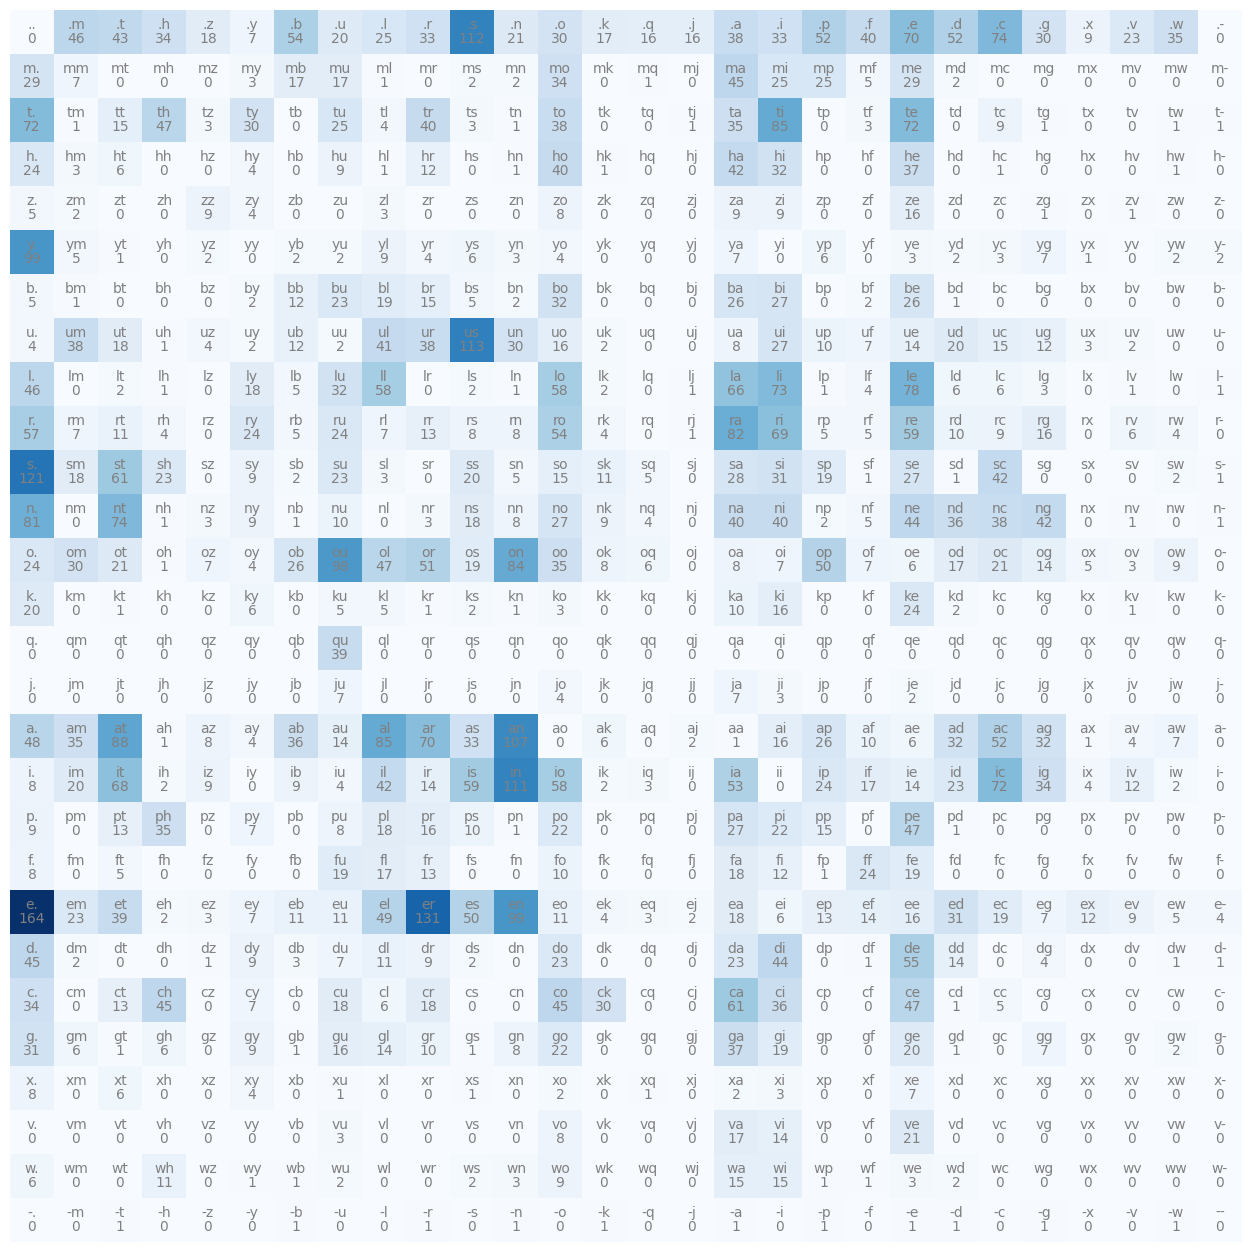

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(N.shape[0]):
    for j in range(N.shape[0]):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')

In [16]:
# create new tensor P to store probabilities
P = (N + 1).float() ## adding fake 1 count to avoid log(0) sutiation during loss calculation!
P = P/P.sum(dim = 1, keepdim = True)

In [17]:
g = torch.Generator().manual_seed(55)

# let's generate some new unique English words!
for i in range(20):
    word = []
    idx = stoi[SPECIAL_TOKEN] # any word always starts with special token '.'
    while True:
        i_probs = P[idx]
        idx = torch.multinomial(i_probs, num_samples = 1, replacement = True, generator = g).item()
        if idx == stoi[SPECIAL_TOKEN]: # if we meet special token - it is the end of the word!
            break  
        word.append(itos[idx])

    print(''.join(word))

wicilin
irataphoonkem
xhacooud
abu
mjugitanusopiteabit
pianglloncrwlon
t
oaru
x
wa
owxe
veriomkjwsuran
h
isall
nthaecrl
honck
kiquophhjircopaianr
w
sonmodle
n


## How good is this bigram model?

In [18]:
# take first two words and check probabilities for pair of characters

for word in words[:2]:
    word = SPECIAL_TOKEN + word + SPECIAL_TOKEN
    for ch1, ch2 in zip(word, word[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]

        print(f'{ch1}{ch2} : {P[idx1, idx2]:.2f}')

.u : 0.02
un : 0.07
nc : 0.07
ci : 0.09
in : 0.16
na : 0.08
at : 0.12
te : 0.14
e. : 0.21
.a : 0.04
ar : 0.09
rg : 0.03
gu : 0.07
ut : 0.04
te : 0.14
e. : 0.21


In [19]:
print(f'If every out of 28 (26 + "-" + special token) chars were equaly likely \
then the probability for each pair of chars would be: {1/28.:.2f}.')

If every out of 28 (26 + "-" + special token) chars were equaly likely then the probability for each pair of chars would be: 0.04.


But we can see above that some of the probabilities are higher than 4% (eg "he : 0.18" or "e. : 0.21").
<br>It means that our bigram model actually learnt something.
<br><br>But how to quantify this in a single number which would expess the quality of our model?
<br>To do this we can use likelihood which can be calculated as `a product of these probabilities`.
<br>`The better the model` we have `the greater the product` value we should get because in a good model all these probabilities should be near 1.
<br>But because all prob values are between 0 and 1 `their product is gonna be a very small number` which is not convinient.
<br>So for convinience what is usually used is **LOG-LIKELIHOOD**.
<br>But it is unnecessary to calculate this tiny product first ang then log(product). 
<br>Logarithm has such a nice property as: `log(a*b*c) = log(a) + log(b) + log(c)`
<br>But again because all prob values are between 0 and 1 all log probs are gonna be negative. In terms of loss function we are actually interested in using this metric is supposing *maximazing* it (because the ideal probs are = 1, log(1) = 0 so the ideal loss value is 0). 
<br>So to make this look more as a loss function we just invert this value. This is how we get **NEGATIVE LOG-LIKELIHOOD**.
<br>`negative log-likelihood = - log-likelihood`
<br> and one more modification: for convinience normilized nll is used which is `NLL = NLL/n` where n is a number of samples

In [15]:
## THIS CELL WORKS ONLY BEFORE ADDING FAKE COUNT (FOR P = N.float())
# we can evaluate how probable any word is given parameters N of our bigram model 
## training loss

log_likelihood = 0.0
n = 0

for word in ["puzqzle"]: # added 'q' on purpose to get rare 'zq' pair of symbols
    word = SPECIAL_TOKEN + word + SPECIAL_TOKEN
    for ch1, ch2 in zip(word, word[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        prob = P[idx1, idx2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2} prob: {prob:.2f}, log: {logprob:.2f}')

nll = -log_likelihood
print(f'negative log-likelihood = {nll}')
print(f'normilized negative log-likelihood = {nll/n}')

# oops! our loss is inf.
# this happened because some of char pairs have 0 occurance in our training set.
# to avoid this problem of getting log(0) we can just add fake counts to our table of frequency.

.p prob: 0.05, log: -2.90
pu prob: 0.03, log: -3.45
uz prob: 0.01, log: -4.70
zq prob: 0.00, log: -inf
qz prob: 0.00, log: -inf
zl prob: 0.04, log: -3.11
le prob: 0.17, log: -1.79
e. prob: 0.21, log: -1.54
negative log-likelihood = inf
normilized negative log-likelihood = inf


In [21]:
## AFTER ADDING FAKE COUNT
log_likelihood = 0.0
n = 0

for word in ["puzqzle"]: # added 'q' on purpose to get rare 'zq' pair of symbols
    word = SPECIAL_TOKEN + word + SPECIAL_TOKEN
    for ch1, ch2 in zip(word, word[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        prob = P[idx1, idx2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2} prob: {prob:.2f}, log: {logprob:.2f}')

nll = -log_likelihood
print(f'negative log-likelihood = {nll}')
print(f'normilized negative log-likelihood = {nll/n}')

.p prob: 0.05, log: -2.91
pu prob: 0.03, log: -3.43
uz prob: 0.01, log: -4.54
zq prob: 0.01, log: -4.55
qz prob: 0.01, log: -4.20
zl prob: 0.04, log: -3.17
le prob: 0.16, log: -1.83
e. prob: 0.21, log: -1.57
negative log-likelihood = 26.2086181640625
normilized negative log-likelihood = 3.2760772705078125


In [20]:
## training loss

log_likelihood = 0.0
n = 0

for word in words:
    word = SPECIAL_TOKEN + word + SPECIAL_TOKEN
    for ch1, ch2 in zip(word, word[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        prob = P[idx1, idx2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1

nll = -log_likelihood
print(f'negative log-likelihood = {nll}')
print(f'normilized negative log-likelihood = {nll/n}')

negative log-likelihood = 23282.662109375
normilized negative log-likelihood = 2.582085132598877
